In [1]:
import Main
import Parser
from Analyser import *

In [2]:
modelName = 'SymTree'

In [3]:
# Some PyABC magic to get our set of parameters
from pyabc import (ABCSMC, Distribution, RV, MultivariateNormalTransition)
import scipy as sp
import scipy.stats as st
import tempfile
import os
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def model(params):
    return Main.generate_and_analyse(modelName, params)

In [5]:
t1 = Main.generate_and_analyse(modelName, {})
t1

{'parentAngle_mean': 29.972552607502287,
 'parentAngle_variance': 0.9070107031211622,
 'length_mean': 5.324752928928331,
 'length_variance': 1.6946616465979092,
 'verticalOrientation_mean': 58.74019847342893,
 'verticalOrientation_variance': 30.950513325864076,
 'horizontalOrientation_mean': 182.37836096148266,
 'horizontalOrientation_variance': 103.94591803983697,
 'q1_xyz': (4.0, 23.2, 4.0),
 'q2_xyz': (87.83338233020078, 20.749719101438767, 78.8915290879336),
 'q3_xyz': (84.79567162826916, 25.26784837685055, 79.87651798927715),
 'xyz': (87.83338233020078, 75.32224617934726, 81.43153915909753),
 'trunk_length': 20.0,
 'totalBiomass': 766.5978275480641}

In [6]:
metrics = {  'slash':(10, 100),
             'slashr':(10, 100),
             'plus':(0, 180),
             'plusr':(0, 180),
             'decay':(0, 1),
             'd': (0, 1),
             'h':(1, 20),
             'w':(0.1, 2),
             'thickness':(0, 4),
             'depth':(1,7)
          }

In [7]:
# prior = Distribution(section_1_slash     =RV("uniform", 10, 100),
#                      section_1_slashr    =RV("uniform", 10, 100),
#                      section_1_plus      =RV("uniform", 0, 180),
#                      section_1_plusr      =RV("uniform", 0, 180),
#                      section_1_decay     =RV("uniform", 0, 1),
#                      section_1_d         =RV("uniform", 0,1),
#                      section_1_h         =RV("uniform", 1, 20),
#                      section_1_w         =RV("uniform", 0.1, 2),
#                      general_thickness   =RV("uniform", 0, 5)
#                     )

In [41]:
slash = Distribution(section_1_slash     =RV("uniform", 10, 100))
slashr = Distribution(section_1_slashr    =RV("uniform", 10, 100))
plus = Distribution(section_1_plus      =RV("uniform", 0, 180))
plusr = Distribution(section_1_plusr      =RV("uniform", 0, 180))
decay = Distribution(section_1_decay     =RV("uniform", 0, 1))
d = Distribution(section_1_d     =RV("uniform", 0, 1))
h = Distribution(section_1_h         =RV("uniform", 1, 20))
w = Distribution(section_1_w         =RV("uniform", 0.2, 1))
thickness = Distribution(general_thickness   =RV("uniform", 0, 5))
depth = Distribution(general_depth           =RV("uniform",1,7))

In [9]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db"))

In [10]:
def gen_av_target(n):
    target = model({})
    for i in range(n):
        print(i)
        new_metrics = model({})
        for (k,v) in new_metrics.items():
            if k[-3:] == 'xyz':
                x,y,z = target[k]
                x += new_metrics[k][0]
                y += new_metrics[k][1]
                z += new_metrics[k][2]
                target[k] = (x,y,z)
            else:
                target[k] += new_metrics[k]

    for (k,v) in target.items():
        if k[-3:] == 'xyz':
            x,y,z = target[k]
            target[k] = (x/n, y/n, z/n)
        else:
            target[k] /= n
            
    return target

In [11]:
target = gen_av_target(20)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [12]:
target

{'parentAngle_mean': 31.471180237877398,
 'parentAngle_variance': 0.9523612382772205,
 'length_mean': 5.590990575374748,
 'length_variance': 1.7793947289278038,
 'verticalOrientation_mean': 61.67720839710038,
 'verticalOrientation_variance': 32.49803899215728,
 'horizontalOrientation_mean': 191.49727900955673,
 'horizontalOrientation_variance': 109.1432139418288,
 'q1_xyz': (4.2, 24.359999999999992, 4.2),
 'q2_xyz': (92.22505144671078, 21.7872050565107, 82.83610554233027),
 'q3_xyz': (89.03545520968264, 26.531240795693087, 83.87034388874096),
 'xyz': (92.22505144671078, 79.08835848831464, 85.50311611705243),
 'trunk_length': 21.0,
 'totalBiomass': 804.9277189254675}

In [13]:
mp = 7
me = 0.5

In [14]:
abc = ABCSMC(model, slash, distance)
abc.new(db_path, target)
history = abc.run(minimum_epsilon=me, max_nr_populations=mp)

INFO:History:Start <ABCSMC(id=67, start_time=2019-04-17 13:48:22.050127, end_time=None)>
INFO:Epsilon:initial epsilon is 11.929907038452086
INFO:ABC:t:0 eps:11.929907038452086
INFO:ABC:t:1 eps:10.031333315394319
INFO:ABC:t:2 eps:7.471585824416362
INFO:ABC:t:3 eps:2.658061923756442
INFO:ABC:t:4 eps:1.7701406293463873
INFO:ABC:t:5 eps:1.0612038832476733
INFO:ABC:t:6 eps:0.9021872876277308
INFO:History:Done <ABCSMC(id=67, start_time=2019-04-17 13:48:22.050127, end_time=2019-04-17 13:49:56.811143)>


In [15]:
from pyabc.visualization import plot_kde_1d

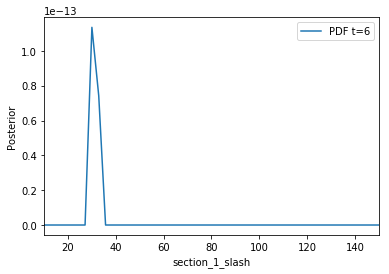

In [18]:
# Visualise results
k = 'slash'
v = metrics[k]
fig, ax = plt.subplots()
for t in range(history.max_t, history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    plot_kde_1d(df, w,
                xmin=v[0], xmax=1.5*v[1],
                x='section_1_slash', ax=ax,
                label="PDF t={}".format(t))
ax.legend();
fig.savefig('../../../../Report/images/individuals/'+k+'_kde')

In [19]:
abc = ABCSMC(model, slashr, distance)
abc.new(db_path, target)
history = abc.run(minimum_epsilon=me, max_nr_populations=mp)

INFO:History:Start <ABCSMC(id=68, start_time=2019-04-17 14:11:28.545778, end_time=None)>
INFO:Epsilon:initial epsilon is 18.034712626607487
INFO:ABC:t:0 eps:18.034712626607487
INFO:ABC:t:1 eps:15.52620858179128
INFO:ABC:t:2 eps:13.678445737328046
INFO:ABC:t:3 eps:11.668726077278347
INFO:ABC:t:4 eps:10.051812683014631
INFO:ABC:t:5 eps:8.398279379637188
INFO:ABC:t:6 eps:5.960160507729393
INFO:History:Done <ABCSMC(id=68, start_time=2019-04-17 14:11:28.545778, end_time=2019-04-17 14:14:20.057506)>


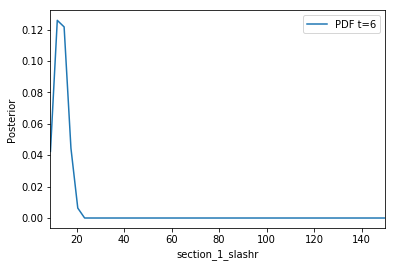

In [20]:
# Visualise results
k = 'slashr'
v = metrics[k]
fig, ax = plt.subplots()
for t in range(history.max_t, history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    plot_kde_1d(df, w,
                xmin=v[0]-1, xmax=1.5*v[1],
                x='section_1_slashr', ax=ax,
                label="PDF t={}".format(t))
ax.legend();
fig.savefig('../../../../Report/images/individuals/'+k+'_kde')

In [21]:
abc = ABCSMC(model, plus, distance)
abc.new(db_path, target)
history = abc.run(minimum_epsilon=me, max_nr_populations=mp)

INFO:History:Start <ABCSMC(id=69, start_time=2019-04-17 14:14:20.228354, end_time=None)>
INFO:Epsilon:initial epsilon is 2.081431660708207
INFO:ABC:t:0 eps:2.081431660708207
INFO:ABC:t:1 eps:1.2983494340011554
INFO:ABC:t:2 eps:1.0198076611611306
INFO:ABC:t:3 eps:0.9377627049460983
INFO:ABC:t:4 eps:0.9150482093868371
INFO:ABC:t:5 eps:0.9080245781223224
INFO:ABC:t:6 eps:0.905703766480899
INFO:History:Done <ABCSMC(id=69, start_time=2019-04-17 14:14:20.228354, end_time=2019-04-17 14:16:11.801861)>


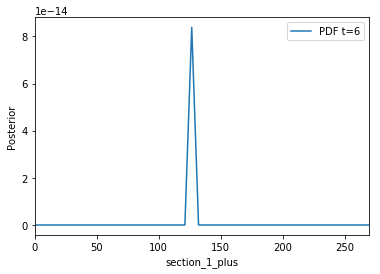

In [23]:
# Visualise results
k = 'plus'
v = metrics[k]
fig, ax = plt.subplots()
for t in range(history.max_t, history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    plot_kde_1d(df, w,
                xmin=v[0], xmax=1.5*v[1],
                x='section_1_plus', ax=ax,
                label="PDF t={}".format(t))
ax.legend();
fig.savefig('../../../../Report/images/individuals/'+k+'_kde')

In [24]:
abc = ABCSMC(model, plusr, distance)
abc.new(db_path, target)
history = abc.run(minimum_epsilon=me, max_nr_populations=mp)

INFO:History:Start <ABCSMC(id=70, start_time=2019-04-17 14:16:46.829727, end_time=None)>
INFO:Epsilon:initial epsilon is 2.001788089012124
INFO:ABC:t:0 eps:2.001788089012124
INFO:ABC:t:1 eps:1.5025063393046063
INFO:ABC:t:2 eps:1.1659126780738749
INFO:ABC:t:3 eps:0.9981806819326431
INFO:ABC:t:4 eps:0.9194493658562978
INFO:ABC:t:5 eps:0.8666876895496337
INFO:ABC:t:6 eps:0.8269606606114677
INFO:History:Done <ABCSMC(id=70, start_time=2019-04-17 14:16:46.829727, end_time=2019-04-17 14:26:27.748947)>


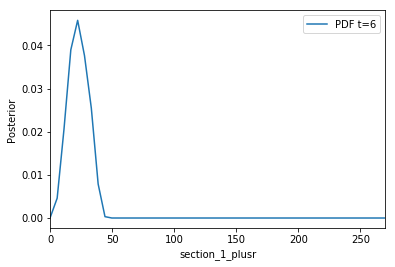

In [25]:
# Visualise results
k = 'plusr'
v = metrics[k]
fig, ax = plt.subplots()
for t in range(history.max_t, history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    plot_kde_1d(df, w,
                xmin=v[0], xmax=1.5*v[1],
                x='section_1_plusr', ax=ax,
                label="PDF t={}".format(t))
ax.legend();
fig.savefig('../../../../Report/images/individuals/'+k+'_kde')

In [26]:
abc = ABCSMC(model, decay, distance)
abc.new(db_path, target)
history = abc.run(minimum_epsilon=me, max_nr_populations=mp)

INFO:History:Start <ABCSMC(id=71, start_time=2019-04-17 14:26:27.946827, end_time=None)>
INFO:Epsilon:initial epsilon is 3.283424168773753
INFO:ABC:t:0 eps:3.283424168773753
INFO:ABC:t:1 eps:2.349257708768707
INFO:ABC:t:2 eps:1.6819951835651024
INFO:ABC:t:3 eps:1.460671293375098
INFO:ABC:t:4 eps:1.2192766567125732
INFO:ABC:t:5 eps:1.0939591973110516
INFO:ABC:t:6 eps:1.0571411546507201
INFO:History:Done <ABCSMC(id=71, start_time=2019-04-17 14:26:27.946827, end_time=2019-04-17 14:30:45.607600)>


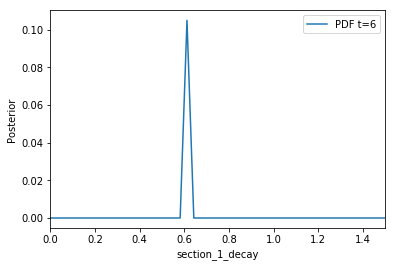

In [27]:
# Visualise results
k = 'decay'
v = metrics[k]
fig, ax = plt.subplots()
for t in range(history.max_t, history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    plot_kde_1d(df, w,
                xmin=v[0], xmax=1.5*v[1],
                x='section_1_decay', ax=ax,
                label="PDF t={}".format(t))
ax.legend();
fig.savefig('../../../../Report/images/individuals/'+k+'_kde')

In [28]:
abc = ABCSMC(model, d, distance)
abc.new(db_path, target)
history = abc.run(minimum_epsilon=me, max_nr_populations=mp)

INFO:History:Start <ABCSMC(id=72, start_time=2019-04-17 14:30:45.787854, end_time=None)>
INFO:Epsilon:initial epsilon is 2.41678491694862
INFO:ABC:t:0 eps:2.41678491694862
INFO:ABC:t:1 eps:1.856333348921058
INFO:ABC:t:2 eps:1.5110627115802069
INFO:ABC:t:3 eps:1.2838979336113556
INFO:ABC:t:4 eps:1.183444196001384
INFO:ABC:t:5 eps:1.1256730288311971
INFO:ABC:t:6 eps:1.0994638252423314
INFO:History:Done <ABCSMC(id=72, start_time=2019-04-17 14:30:45.787854, end_time=2019-04-17 14:37:00.348859)>


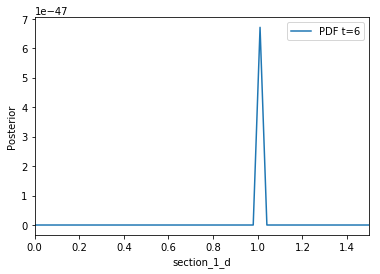

In [29]:
# Visualise results
k = 'd'
v = metrics[k]
fig, ax = plt.subplots()
for t in range(history.max_t, history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    plot_kde_1d(df, w,
                xmin=v[0], xmax=1.5*v[1],
                x='section_1_d', ax=ax,
                label="PDF t={}".format(t))
ax.legend();
fig.savefig('../../../../Report/images/individuals/'+k+'_kde')

In [31]:
abc = ABCSMC(model, h, distance)
abc.new(db_path, target)
history = abc.run(minimum_epsilon=me, max_nr_populations=mp)

INFO:History:Start <ABCSMC(id=74, start_time=2019-04-17 15:45:29.618818, end_time=None)>
INFO:Epsilon:initial epsilon is 17.134535714544228
INFO:ABC:t:0 eps:17.134535714544228
INFO:ABC:t:1 eps:13.037025857426896
INFO:ABC:t:2 eps:10.342176057400101
INFO:ABC:t:3 eps:8.808659440258875
INFO:ABC:t:4 eps:7.408316355301115
INFO:ABC:t:5 eps:5.792292791730927
INFO:ABC:t:6 eps:4.8607409373132215
INFO:History:Done <ABCSMC(id=74, start_time=2019-04-17 15:45:29.618818, end_time=2019-04-17 15:50:08.652447)>


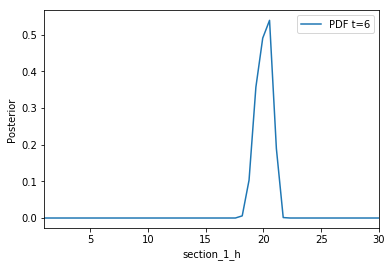

In [32]:
# Visualise results
k = 'h'
v = metrics[k]
fig, ax = plt.subplots()
for t in range(history.max_t, history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    plot_kde_1d(df, w,
                xmin=v[0], xmax=1.5*v[1],
                x='section_1_h', ax=ax,
                label="PDF t={}".format(t))
ax.legend();
fig.savefig('../../../../Report/images/individuals/'+k+'_kde')

In [42]:
abc = ABCSMC(model, w, distance)
abc.new(db_path, target)
history = abc.run(minimum_epsilon=me, max_nr_populations=mp)

INFO:History:Start <ABCSMC(id=81, start_time=2019-04-17 16:32:29.467241, end_time=None)>
INFO:Epsilon:initial epsilon is 12.528163911926898
INFO:ABC:t:0 eps:12.528163911926898
INFO:ABC:t:1 eps:9.85250653266354
INFO:ABC:t:2 eps:7.967636645668459
INFO:ABC:t:3 eps:6.191206696012126
INFO:ABC:t:4 eps:5.223978945540769
INFO:ABC:t:5 eps:4.6684191531945185
INFO:ABC:t:6 eps:4.402315713840879
INFO:History:Done <ABCSMC(id=81, start_time=2019-04-17 16:32:29.467241, end_time=2019-04-17 16:38:03.511550)>


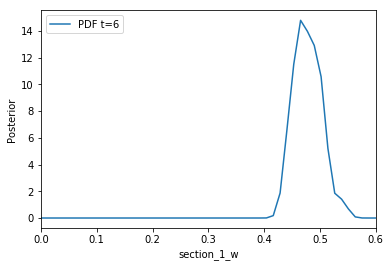

In [43]:
# Visualise results
k = 'w'
v = metrics[k]
fig, ax = plt.subplots()
for t in range(history.max_t, history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    plot_kde_1d(df, w,
                xmin=0, xmax=0.6,
                x='section_1_w', ax=ax,
                label="PDF t={}".format(t))
ax.legend();
fig.savefig('../../../../Report/images/individuals/'+k+'_kde')

In [35]:
abc = ABCSMC(model, thickness, distance)
abc.new(db_path, target)
history = abc.run(minimum_epsilon=me, max_nr_populations=mp)

INFO:History:Start <ABCSMC(id=77, start_time=2019-04-17 15:53:41.996715, end_time=None)>
INFO:Epsilon:initial epsilon is 11.072162188334586
INFO:ABC:t:0 eps:11.072162188334586
INFO:ABC:t:1 eps:8.808714564015563
INFO:ABC:t:2 eps:7.179598664094241
INFO:ABC:t:3 eps:5.8837832206394545
INFO:ABC:t:4 eps:5.097814966135824
INFO:ABC:t:5 eps:4.757284346360755
INFO:ABC:t:6 eps:4.533243402637724
INFO:History:Done <ABCSMC(id=77, start_time=2019-04-17 15:53:41.996715, end_time=2019-04-17 16:00:12.140265)>


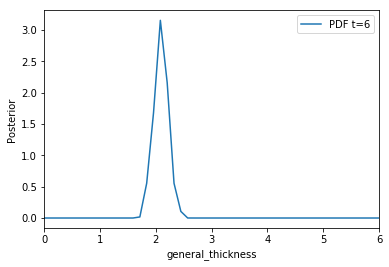

In [36]:
# Visualise results
k = 'thickness'
v = metrics[k]
fig, ax = plt.subplots()
for t in range(history.max_t, history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    plot_kde_1d(df, w,
                xmin=v[0], xmax=1.5*v[1],
                x='general_thickness', ax=ax,
                label="PDF t={}".format(t))
ax.legend();
fig.savefig('../../../../Report/images/individuals/'+k+'_kde')

In [37]:
abc = ABCSMC(model, depth, distance)
abc.new(db_path, target)
history = abc.run(minimum_epsilon=me, max_nr_populations=mp)

INFO:History:Start <ABCSMC(id=78, start_time=2019-04-17 16:00:12.307769, end_time=None)>
INFO:Epsilon:initial epsilon is 12.054699807051733
INFO:ABC:t:0 eps:12.054699807051733
INFO:ABC:t:1 eps:9.365022680577034
INFO:ABC:t:2 eps:7.034874792504597
INFO:ABC:t:3 eps:5.454979972560287
INFO:ABC:t:4 eps:4.877867766149941
INFO:ABC:t:5 eps:4.527704046545848
INFO:ABC:t:6 eps:4.335654047115792
INFO:History:Done <ABCSMC(id=78, start_time=2019-04-17 16:00:12.307769, end_time=2019-04-17 16:08:13.421065)>


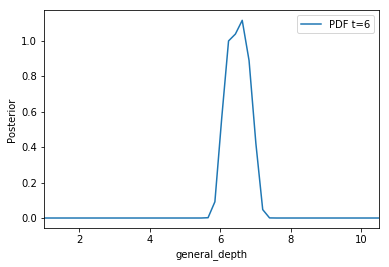

In [38]:
# Visualise results
k = 'depth'
v = metrics[k]
fig, ax = plt.subplots()
for t in range(history.max_t, history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    plot_kde_1d(df, w,
                xmin=v[0], xmax=1.5*v[1],
                x='general_depth', ax=ax,
                label="PDF t={}".format(t))
ax.legend();
fig.savefig('../../../../Report/images/individuals/'+k+'_kde')